In [19]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import time

In [20]:
# Carregar e processar dados
df = pd.read_csv('Dados Históricos - Ibovespa.csv', encoding='utf-8')
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
df = df.sort_values('Data').reset_index(drop=True)

# Converter volume
def converter_volume(vol_str):
    if pd.isna(vol_str): return np.nan
    vol_str = str(vol_str).replace(',', '.')
    if 'B' in vol_str: return float(vol_str.replace('B', '')) * 1e9
    elif 'M' in vol_str: return float(vol_str.replace('M', '')) * 1e6
    elif 'K' in vol_str: return float(vol_str.replace('K', '')) * 1e3
    return float(vol_str)

df['Volume'] = df['Vol.'].apply(converter_volume)
df['Variacao'] = df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float) / 100
df['Target'] = (df['Variacao'].shift(-1) > 0).astype(int)
df = df[:-1].copy()

print(f"Dataset processado: {df.shape}")

Dataset processado: (3591, 10)


In [21]:
# Criar features técnicas
df_features = df.copy()

# Médias móveis
for periodo in [5, 10, 20, 50]:
    df_features[f'MA_{periodo}'] = df_features['Último'].rolling(window=periodo).mean()

# Bandas de Bollinger
df_features['BB_Middle'] = df_features['Último'].rolling(window=20).mean()
bb_std = df_features['Último'].rolling(window=20).std()
df_features['BB_Upper'] = df_features['BB_Middle'] + (bb_std * 2)
df_features['BB_Lower'] = df_features['BB_Middle'] - (bb_std * 2)
df_features['BB_Width'] = df_features['BB_Upper'] - df_features['BB_Lower']
df_features['BB_Position'] = (df_features['Último'] - df_features['BB_Lower']) / df_features['BB_Width']

# RSI
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_features['RSI'] = calculate_rsi(df_features['Último'])

# MACD
ema_12 = df_features['Último'].ewm(span=12).mean()
ema_26 = df_features['Último'].ewm(span=26).mean()
df_features['MACD'] = ema_12 - ema_26
df_features['Signal_Line'] = df_features['MACD'].ewm(span=9).mean()

# ATR
df_features['high_low'] = df_features['Máxima'] - df_features['Mínima']
df_features['high_close_prev'] = abs(df_features['Máxima'] - df_features['Último'].shift(1))
df_features['low_close_prev'] = abs(df_features['Mínima'] - df_features['Último'].shift(1))
df_features['true_range'] = df_features[['high_low', 'high_close_prev', 'low_close_prev']].max(axis=1)

for periodo in [5, 10, 20]:
    df_features[f'atr_{periodo}'] = df_features['true_range'].rolling(window=periodo).mean()

# Volatilidade
df_features['returns'] = df_features['Último'].pct_change()
for periodo in [5, 10, 20]:
    df_features[f'volatility_{periodo}'] = df_features['returns'].rolling(window=periodo).std()

# Features de preço
df_features['Price_Range'] = df_features['Máxima'] - df_features['Mínima']
df_features['Price_Position'] = (df_features['Último'] - df_features['Mínima']) / df_features['Price_Range']
df_features['Gap'] = df_features['Abertura'] - df_features['Último'].shift(1)
df_features['hl_close_ratio'] = (df_features['Máxima'] - df_features['Mínima']) / df_features['Último']

# Features temporais
df_features['day_of_week'] = df_features['Data'].dt.dayofweek
df_features['month'] = df_features['Data'].dt.month
df_features['quarter'] = df_features['Data'].dt.quarter
df_features['is_month_start'] = (df_features['Data'].dt.day <= 5).astype(int)
df_features['is_month_end'] = (df_features['Data'].dt.day >= 25).astype(int)

print(f"Features técnicas criadas: {df_features.shape}")

Features técnicas criadas: (3591, 42)


In [22]:
# Aplicar correção temporal
features_to_shift = [
    'Abertura', 'Máxima', 'Mínima', 'Último', 'Volume',
    'MA_5', 'MA_10', 'MA_20', 'MA_50',
    'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'BB_Middle',
    'RSI', 'MACD', 'Signal_Line',
    'atr_5', 'atr_10', 'atr_20',
    'volatility_5', 'volatility_10', 'volatility_20',
    'Price_Range', 'Price_Position', 'Gap', 'hl_close_ratio',
    'true_range', 'high_close_prev', 'low_close_prev', 'high_low',
    'returns', 'Variacao'
]

features_no_shift = [
    'Data', 'day_of_week', 'month', 'quarter',
    'is_month_start', 'is_month_end', 'Target'
]

# Dataset A (Baseline) - sem candlestick
dataset_a = pd.DataFrame()
for feature in features_no_shift:
    if feature in df_features.columns:
        dataset_a[feature] = df_features[feature]

for feature in features_to_shift:
    if feature in df_features.columns:
        dataset_a[f'{feature}_shifted'] = df_features[feature].shift(1)

dataset_a = dataset_a.iloc[1:].reset_index(drop=True)

print(f"Dataset A (Baseline): {dataset_a.shape}")

Dataset A (Baseline): (3590, 40)


In [23]:
# Criar features de candlestick
dataset_b = dataset_a.copy()

# Usar colunas OHLC shifted
ohlc_cols = ['Abertura_shifted', 'Máxima_shifted', 'Mínima_shifted', 'Último_shifted']
if all(col in dataset_b.columns for col in ohlc_cols):
    ohlc_temp = dataset_b[ohlc_cols].copy()
    ohlc_temp.columns = ['Open', 'High', 'Low', 'Close']
    
    # Padrões de candlestick
    def detect_doji(df, threshold=0.1):
        body_size = abs(df['Close'] - df['Open'])
        total_range = df['High'] - df['Low']
        return (body_size / total_range < threshold).astype(int)
    
    def detect_hammer(df):
        body_size = abs(df['Close'] - df['Open'])
        lower_shadow = df[['Open', 'Close']].min(axis=1) - df['Low']
        upper_shadow = df['High'] - df[['Open', 'Close']].max(axis=1)
        return ((lower_shadow > 2 * body_size) & (upper_shadow < body_size)).astype(int)
    
    def detect_shooting_star(df):
        body_size = abs(df['Close'] - df['Open'])
        lower_shadow = df[['Open', 'Close']].min(axis=1) - df['Low']
        upper_shadow = df['High'] - df[['Open', 'Close']].max(axis=1)
        return ((upper_shadow > 2 * body_size) & (lower_shadow < body_size)).astype(int)
    
    def detect_engulfing_bullish(df):
        current_bullish = df['Close'] > df['Open']
        prev_bearish = (df['Close'].shift(1) < df['Open'].shift(1))
        current_open_below_prev_close = df['Open'] < df['Close'].shift(1)
        current_close_above_prev_open = df['Close'] > df['Open'].shift(1)
        return (current_bullish & prev_bearish & current_open_below_prev_close & current_close_above_prev_open).astype(int)
    
    # Aplicar padrões
    dataset_b['doji_prev'] = detect_doji(ohlc_temp)
    dataset_b['hammer_prev'] = detect_hammer(ohlc_temp)
    dataset_b['shooting_star_prev'] = detect_shooting_star(ohlc_temp)
    dataset_b['engulfing_bullish_prev'] = detect_engulfing_bullish(ohlc_temp)
    dataset_b['bullish_candle_prev'] = (ohlc_temp['Close'] > ohlc_temp['Open']).astype(int)
    dataset_b['bearish_candle_prev'] = (ohlc_temp['Close'] < ohlc_temp['Open']).astype(int)
    dataset_b['body_size_prev'] = abs(ohlc_temp['Close'] - ohlc_temp['Open'])
    dataset_b['upper_shadow_prev'] = ohlc_temp['High'] - ohlc_temp[['Open', 'Close']].max(axis=1)
    dataset_b['lower_shadow_prev'] = ohlc_temp[['Open', 'Close']].min(axis=1) - ohlc_temp['Low']

print(f"Dataset B (Enriquecido): {dataset_b.shape}")
print(f"Diferença: +{dataset_b.shape[1] - dataset_a.shape[1]} features")

Dataset B (Enriquecido): (3590, 49)
Diferença: +9 features


In [24]:
# Preparar splits temporais
def create_temporal_split(df, test_size=0.2):
    df_sorted = df.sort_values('Data').reset_index(drop=True) if 'Data' in df.columns else df.copy()
    split_idx = int(len(df_sorted) * (1 - test_size))
    
    train_df = df_sorted.iloc[:split_idx]
    test_df = df_sorted.iloc[split_idx:]
    
    feature_cols = [col for col in df_sorted.columns if col not in ['Data', 'Target']]
    
    X_train = train_df[feature_cols]
    X_test = test_df[feature_cols]
    y_train = train_df['Target']
    y_test = test_df['Target']
    
    return X_train, X_test, y_train, y_test

X_train_a, X_test_a, y_train_a, y_test_a = create_temporal_split(dataset_a)
X_train_b, X_test_b, y_train_b, y_test_b = create_temporal_split(dataset_b)

# Remover NaN
X_train_a = X_train_a.fillna(method='ffill').fillna(0)
X_test_a = X_test_a.fillna(method='ffill').fillna(0)
X_train_b = X_train_b.fillna(method='ffill').fillna(0)
X_test_b = X_test_b.fillna(method='ffill').fillna(0)

print(f"Dataset A - Train: {X_train_a.shape}, Test: {X_test_a.shape}")
print(f"Dataset B - Train: {X_train_b.shape}, Test: {X_test_b.shape}")
print(f"NaN removidos")

Dataset A - Train: (2872, 38), Test: (718, 38)
Dataset B - Train: (2872, 47), Test: (718, 47)
NaN removidos


In [25]:
# Definir modelos
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(C=0.1, solver='liblinear', random_state=42))
    ]),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5,
        min_samples_leaf=2, random_state=42, n_jobs=-1
    ),
    
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss'
    ),
    
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1
    ),
    
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', probability=True, random_state=42, C=1.0))
    ])
}

print(f"Modelos preparados: {list(models.keys())}")

Modelos preparados: ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'SVM']


In [26]:
# Função de avaliação
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, dataset_name):
    start_time = time.time()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    training_time = time.time() - start_time
    
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='accuracy')
    
    return {
        'model_name': model_name,
        'dataset': dataset_name,
        'accuracy': accuracy,
        'auc_score': auc_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'training_time': training_time,
        'model': model
    }

print("Função de avaliação preparada")

Função de avaliação preparada


In [27]:
# Executar olimpíada
results = []

for model_name, model in models.items():
    print(f"\nTestando {model_name}...")
    
    # Dataset A
    try:
        result_a = evaluate_model(model, X_train_a, X_test_a, y_train_a, y_test_a, 
                                model_name, "Dataset A")
        results.append(result_a)
        auc_str_a = f'{result_a["auc_score"]:.4f}' if result_a['auc_score'] else 'N/A'
        print(f'  Dataset A: Acc={result_a["accuracy"]:.4f}, AUC={auc_str_a}')

    except Exception as e:
        print(f"  Dataset A: Error - {e}")
    
    # Dataset B
    try:
        result_b = evaluate_model(model, X_train_b, X_test_b, y_train_b, y_test_b, 
                                model_name, "Dataset B")
        results.append(result_b)
        auc_str_b = f'{result_b["auc_score"]:.4f}' if result_b['auc_score'] else 'N/A'
        print(f'  Dataset B: Acc={result_b["accuracy"]:.4f}, AUC={auc_str_b}')

        
        if len(results) >= 2:
            diff = result_b['accuracy'] - result_a['accuracy']
            print(f"  Diferença: {diff:+.4f}")
    except Exception as e:
        print(f"  Dataset B: Error - {e}")

print(f"\nResultados coletados: {len(results)}")


Testando Logistic Regression...
  Dataset A: Acc=0.4875, AUC=0.5031
  Dataset B: Acc=0.4861, AUC=0.5094
  Diferença: -0.0014

Testando Random Forest...
  Dataset A: Acc=0.5334, AUC=0.5379
  Dataset B: Acc=0.5195, AUC=0.5337
  Diferença: -0.0139

Testando XGBoost...
  Dataset A: Acc=0.5306, AUC=0.5392
  Dataset B: Acc=0.5404, AUC=0.5456
  Diferença: +0.0097

Testando LightGBM...
  Dataset A: Acc=0.4986, AUC=0.4979
  Dataset B: Acc=0.5237, AUC=0.5243
  Diferença: +0.0251

Testando SVM...
  Dataset A: Acc=0.5460, AUC=0.4560
  Dataset B: Acc=0.5376, AUC=0.4540
  Diferença: -0.0084

Resultados coletados: 10


In [28]:
# Análise dos resultados
if results:
    results_df = pd.DataFrame(results)
    
    print("\nTabela de Resultados:")
    print(f"{'Modelo':<20} {'Dataset':<12} {'Accuracy':<10} {'AUC':<8} {'CV Mean':<10} {'Tempo':<8}")
    print("-" * 75)
    
    for _, row in results_df.iterrows():
        auc_str = f"{row['auc_score']:.4f}" if row['auc_score'] is not None else "N/A"
        print(f"{row['model_name']:<20} {row['dataset']:<12} {row['accuracy']:<10.4f} {auc_str:<8} {row['cv_mean']:<10.4f} {row['training_time']:<8.2f}")
    
    # Ranking por dataset
    print("\nRanking Dataset A:")
    dataset_a_results = results_df[results_df['dataset'] == 'Dataset A'].sort_values('accuracy', ascending=False)
    for i, (_, row) in enumerate(dataset_a_results.iterrows(), 1):
        print(f"  {i}. {row['model_name']}: {row['accuracy']:.4f}")
    
    print("\nRanking Dataset B:")
    dataset_b_results = results_df[results_df['dataset'] == 'Dataset B'].sort_values('accuracy', ascending=False)
    for i, (_, row) in enumerate(dataset_b_results.iterrows(), 1):
        print(f"  {i}. {row['model_name']}: {row['accuracy']:.4f}")
    
    # Impacto das features de candlestick
    print("\nImpacto das Features de Candlestick:")
    candlestick_impact = []
    
    for model_name in results_df['model_name'].unique():
        model_results = results_df[results_df['model_name'] == model_name]
        if len(model_results) == 2:
            baseline = model_results[model_results['dataset'] == 'Dataset A'].iloc[0]
            enriched = model_results[model_results['dataset'] == 'Dataset B'].iloc[0]
            
            improvement = enriched['accuracy'] - baseline['accuracy']
            candlestick_impact.append(improvement)
            
            print(f"  {model_name}: {baseline['accuracy']:.4f} -> {enriched['accuracy']:.4f} ({improvement:+.4f})")
    
    if candlestick_impact:
        avg_improvement = np.mean(candlestick_impact)
        positive_count = sum(1 for x in candlestick_impact if x > 0)
        
        print(f"\nResumo do Impacto:")
        print(f"  Melhoria média: {avg_improvement:+.4f}")
        print(f"  Modelos que melhoraram: {positive_count}/{len(candlestick_impact)}")
        
        if avg_improvement > 0.01:
            print(f"  Conclusão: Features de candlestick agregam valor significativo")
        elif avg_improvement > 0:
            print(f"  Conclusão: Features de candlestick agregam valor marginal")
        else:
            print(f"  Conclusão: Features de candlestick não agregam valor")
    
    # Campeão geral
    best_result = results_df.loc[results_df['accuracy'].idxmax()]
    print(f"\nCampeão Geral:")
    print(f"  Modelo: {best_result['model_name']}")
    print(f"  Dataset: {best_result['dataset']}")
    print(f"  Accuracy: {best_result['accuracy']:.4f}")
    print(f"  AUC: {best_result['auc_score']:.4f}" if best_result['auc_score'] else "  AUC: N/A")

else:
    print("Nenhum resultado coletado")


Tabela de Resultados:
Modelo               Dataset      Accuracy   AUC      CV Mean    Tempo   
---------------------------------------------------------------------------
Logistic Regression  Dataset A    0.4875     0.5031   0.5013     0.06    
Logistic Regression  Dataset B    0.4861     0.5094   0.4971     0.04    
Random Forest        Dataset A    0.5334     0.5379   0.4950     0.42    
Random Forest        Dataset B    0.5195     0.5337   0.4858     0.31    
XGBoost              Dataset A    0.5306     0.5392   0.5067     0.55    
XGBoost              Dataset B    0.5404     0.5456   0.4962     0.41    
LightGBM             Dataset A    0.4986     0.4979   0.5038     1.57    
LightGBM             Dataset B    0.5237     0.5243   0.5113     0.11    
SVM                  Dataset A    0.5460     0.4560   0.4874     2.82    
SVM                  Dataset B    0.5376     0.4540   0.4854     3.09    

Ranking Dataset A:
  1. SVM: 0.5460
  2. Random Forest: 0.5334
  3. XGBoost: 0.5306
  

In [29]:
# Ensemble dos melhores
if len(results) >= 6:  # Pelo menos 3 modelos testados em ambos datasets
    dataset_b_results = [r for r in results if r['dataset'] == 'Dataset B']
    
    if len(dataset_b_results) >= 3:
        dataset_b_results.sort(key=lambda x: x['accuracy'], reverse=True)
        top_3 = dataset_b_results[:3]
        
        print(f"\nTop 3 para ensemble: {[r['model_name'] for r in top_3]}")
        
        ensemble_estimators = []
        for i, result in enumerate(top_3):
            name = f"model_{i+1}"
            ensemble_estimators.append((name, result['model']))
        
        voting_classifier = VotingClassifier(estimators=ensemble_estimators, voting='soft')
        
        try:
            ensemble_result = evaluate_model(
                voting_classifier, X_train_b, X_test_b, y_train_b, y_test_b,
                "Voting Classifier", "Dataset B"
            )
            
            print(f"\nEnsemble Result:")
            print(f"  Accuracy: {ensemble_result['accuracy']:.4f}")
            print(f"  AUC: {ensemble_result['auc_score']:.4f}")
            
            best_individual = top_3[0]
            improvement = ensemble_result['accuracy'] - best_individual['accuracy']
            print(f"  vs Best Individual: {improvement:+.4f}")
            
            results.append(ensemble_result)
            
        except Exception as e:
            print(f"Ensemble error: {e}")

print("\nOlimpíada concluída")


Top 3 para ensemble: ['XGBoost', 'SVM', 'LightGBM']

Ensemble Result:
  Accuracy: 0.5362
  AUC: 0.5380
  vs Best Individual: -0.0042

Olimpíada concluída


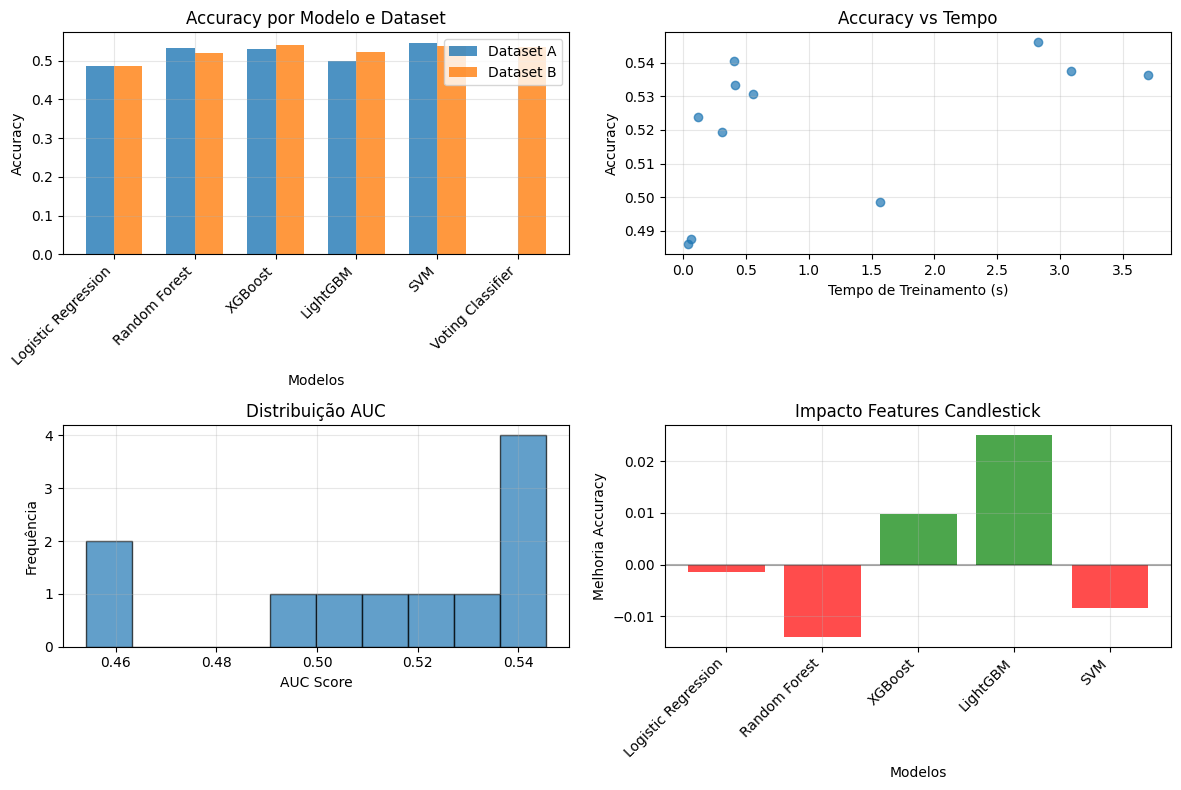

Análise visual concluída


In [30]:
# Visualização simples
if results:
    results_df = pd.DataFrame(results)
    
    plt.figure(figsize=(12, 8))
    
    # Gráfico de accuracy por modelo e dataset
    plt.subplot(2, 2, 1)
    models_list = results_df['model_name'].unique()
    datasets_list = results_df['dataset'].unique()
    
    x = np.arange(len(models_list))
    width = 0.35
    
    for i, dataset in enumerate(datasets_list):
        dataset_data = results_df[results_df['dataset'] == dataset]
        accuracies = []
        
        for model in models_list:
            model_data = dataset_data[dataset_data['model_name'] == model]
            if len(model_data) > 0:
                accuracies.append(model_data.iloc[0]['accuracy'])
            else:
                accuracies.append(0)
        
        plt.bar(x + i*width, accuracies, width, label=dataset, alpha=0.8)
    
    plt.xlabel('Modelos')
    plt.ylabel('Accuracy')
    plt.title('Accuracy por Modelo e Dataset')
    plt.xticks(x + width/2, models_list, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Tempo vs Accuracy
    plt.subplot(2, 2, 2)
    plt.scatter([r['training_time'] for r in results], 
               [r['accuracy'] for r in results], alpha=0.7)
    plt.xlabel('Tempo de Treinamento (s)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Tempo')
    plt.grid(True, alpha=0.3)
    
    # Distribuição de AUC
    plt.subplot(2, 2, 3)
    auc_scores = [r['auc_score'] for r in results if r['auc_score'] is not None]
    if auc_scores:
        plt.hist(auc_scores, bins=10, alpha=0.7, edgecolor='black')
        plt.xlabel('AUC Score')
        plt.ylabel('Frequência')
        plt.title('Distribuição AUC')
        plt.grid(True, alpha=0.3)
    
    # Impacto candlestick
    plt.subplot(2, 2, 4)
    if 'candlestick_impact' in locals() and candlestick_impact:
        models_impact = [results_df[results_df['model_name'] == model]['model_name'].iloc[0] 
                        for model in results_df['model_name'].unique() 
                        if len(results_df[results_df['model_name'] == model]) == 2]
        
        if len(models_impact) == len(candlestick_impact):
            colors = ['green' if x > 0 else 'red' for x in candlestick_impact]
            plt.bar(models_impact, candlestick_impact, color=colors, alpha=0.7)
            plt.xlabel('Modelos')
            plt.ylabel('Melhoria Accuracy')
            plt.title('Impacto Features Candlestick')
            plt.xticks(rotation=45, ha='right')
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Análise visual concluída")